In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

spark = SparkSession.builder \
    .appName("FlightDelayPrediction") \
    .getOrCreate()

DATA_PATH = "/Users/parthmac/Desktop/Projects/Flight Data Analysis/data/wrangled data /flattened_flight_data_parquet"  # change this path to where your data is stored

try:
    df = spark.read.parquet(DATA_PATH)
except Exception:
    df = spark.read.csv(DATA_PATH, header=True, inferSchema=True)

print("Number of rows:", df.count())
print("Number of columns:", len(df.columns))
df.printSchema()

# peek at sample
df.limit(5).toPandas()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/09/02 11:00:30 WARN Utils: Your hostname, Parths-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.249 instead (on interface en0)
25/09/02 11:00:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/02 11:00:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Number of rows: 100000
Number of columns: 46
root
 |-- aircraft_iata: string (nullable = true)
 |-- aircraft_icao: string (nullable = true)
 |-- aircraft_icao24: string (nullable = true)
 |-- aircraft_manufacturer: string (nullable = true)
 |-- aircraft_model: string (nullable = true)
 |-- aircraft_registration: string (nullable = true)
 |-- airline_iata: string (nullable = true)
 |-- airline_icao: string (nullable = true)
 |-- airline_name: string (nullable = true)
 |-- arrival_actual: string (nullable = true)
 |-- arrival_actual_runway: string (nullable = true)
 |-- arrival_airport: string (nullable = true)
 |-- arrival_baggage: string (nullable = true)
 |-- arrival_delay: long (nullable = true)
 |-- arrival_estimated: string (nullable = true)
 |-- arrival_estimated_runway: string (nullable = true)
 |-- arrival_gate: string (nullable = true)
 |-- arrival_iata: string (nullable = true)
 |-- arrival_icao: string (nullable = true)
 |-- arrival_scheduled: string (nullable = true)
 |-- ar

25/09/02 11:00:33 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,aircraft_iata,aircraft_icao,aircraft_icao24,aircraft_manufacturer,aircraft_model,aircraft_registration,airline_iata,airline_icao,airline_name,arrival_actual,...,flight_codeshared_airline_name,flight_codeshared_flight_iata,flight_codeshared_flight_icao,flight_codeshared_flight_number,flight_iata,flight_icao,flight_number,flight_date,flight_status,live
0,738,B738,10e7a2,Boeing,737-800,9V-06U,BA,BAW,British Airways,None,...,air india,ai6796,aic6796,6796,BA844,BAW844,844,2025-08-29,cancelled,None
1,A320,A320,e6c934,Airbus,A320-200,B-UEQ,AV,AVA,Avianca,2025-08-29T18:50:00+00:00,...,None,None,None,None,AV1206,AVA1206,1206,2025-08-29,landed,None
2,738,B738,3d7ae3,Boeing,737-800,JA-IPB,SG,SEJ,SpiceJet,2025-08-29T06:27:00+00:00,...,None,None,None,None,SG9567,SEJ9567,9567,2025-08-29,landed,None
3,E95,E295,7945cd,Embraer,E195-E2,B-A3A,GA,GIA,Garuda Indonesia,2025-08-29T11:24:00+00:00,...,None,None,None,None,GA7713,GIA7713,7713,2025-08-29,landed,None
4,AT7,AT76,04ed00,ATR,72-600,B-4VN,WN,SWA,Southwest Airlines,2025-08-29T16:42:00+00:00,...,delta air lines,dl7987,dal7987,7987,WN9975,SWA9975,9975,2025-08-29,landed,None


In [ ]:
# pick arrival_scheduled if available, else departure_scheduled
if "arrival_scheduled" in df.columns:
    ts_col = "arrival_scheduled"
elif "departure_scheduled" in df.columns:
    ts_col = "departure_scheduled"
else:
    raise ValueError("No scheduled time column found in data!")

df = (
    df.withColumn("_ts", F.to_timestamp(F.col(ts_col)))
      .withColumn("sched_hour", F.hour(F.col("_ts")))
      .withColumn("sched_dayofweek", F.dayofweek(F.col("_ts")))
      .withColumn("sched_dayofmonth", F.dayofmonth(F.col("_ts")))
      .withColumn("sched_month", F.month(F.col("_ts")))
      .withColumn("sched_weekofyear", F.weekofyear(F.col("_ts")))
      .drop("_ts")
)

df.select(
    ts_col, 
    "sched_hour", 
    "sched_dayofweek", 
    "sched_dayofmonth", 
    "sched_month", 
    "sched_weekofyear"
).limit(5).toPandas()

,arrival_scheduled,sched_hour,sched_dayofweek,sched_dayofmonth,sched_month,sched_weekofyear
0,2025-08-29T10:00:00+00:00,15,6,29,8,35
1,2025-08-29T18:50:00+00:00,0,7,30,8,35
2,2025-08-29T06:27:00+00:00,11,6,29,8,35
3,2025-08-29T11:24:00+00:00,16,6,29,8,35
4,2025-08-29T16:42:00+00:00,22,6,29,8,35


In [ ]:
# Step 4: Prepare labels
DELAY_THRESHOLD = 15  # minutes

# Regression label: keep arrival_delay as-is
# Classification label: 1 if arrival_delay > threshold else 0
df = df.withColumn(
    "label_delay_binary",
    F.when(F.col("arrival_delay") > DELAY_THRESHOLD, 1).otherwise(0)
)

# Show some samples
df.select("arrival_delay", "label_delay_binary").limit(10).toPandas()


,arrival_delay,label_delay_binary
0,NaN,0
1,28.0,1
2,33.0,1
3,17.0,1
4,15.0,0
5,NaN,0
6,32.0,1
7,31.0,1
8,NaN,0
9,NaN,0


In [ ]:
# Keep only rows with valid arrival_delay
df_cls = df.na.drop(subset=["arrival_delay"])

print("Total rows after dropping nulls:", df_cls.count())
df_cls.select("arrival_delay", "label_delay_binary").show(10)

Total rows after dropping nulls: 44821
+-------------+------------------+
|arrival_delay|label_delay_binary|
+-------------+------------------+
|           28|                 1|
|           33|                 1|
|           17|                 1|
|           15|                 0|
|           32|                 1|
|           31|                 1|
|           51|                 1|
|           35|                 1|
|           28|                 1|
|            6|                 0|
+-------------+------------------+
only showing top 10 rows


In [ ]:
# Step 5.1: Define categorical and numeric features
categorical_cols = ["airline_iata", "departure_airport", "arrival_airport", "aircraft_model"]
numeric_cols = ["sched_hour", "sched_dayofweek", "sched_dayofmonth", "sched_month", "sched_weekofyear"]

# Step 5.2: Index and OneHotEncode categoricals
indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+"_idx", outputCol=col+"_ohe") for col in categorical_cols]

# Step 5.3: Assemble all features
assembler_inputs = [col+"_ohe" for col in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# Step 5.4: Build pipeline
preprocess_pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit + transform
df_prepared = preprocess_pipeline.fit(df_cls).transform(df_cls)

# Show schema
df_prepared.select("features", "label_delay_binary").show(5, truncate=False)

+-----------------------------------------------------------------------------------+------------------+
|features                                                                           |label_delay_binary|
+-----------------------------------------------------------------------------------+------------------+
|(255,[12,100,204,245,251,252,253,254],[1.0,1.0,1.0,1.0,7.0,30.0,8.0,35.0])         |1                 |
|(255,[47,128,162,248,250,251,252,253,254],[1.0,1.0,1.0,1.0,11.0,6.0,29.0,8.0,35.0])|1                 |
|(255,[26,139,228,247,250,251,252,253,254],[1.0,1.0,1.0,1.0,16.0,6.0,29.0,8.0,35.0])|1                 |
|(255,[22,105,175,246,250,251,252,253,254],[1.0,1.0,1.0,1.0,22.0,6.0,29.0,8.0,35.0])|0                 |
|(255,[9,56,196,245,250,251,252,253,254],[1.0,1.0,1.0,1.0,23.0,6.0,29.0,8.0,35.0])  |1                 |
+-----------------------------------------------------------------------------------+------------------+
only showing top 5 rows


In [ ]:
# Step 6.1: Train/Test Split
train_df, test_df = df_prepared.randomSplit([0.8, 0.2], seed=42)

print("Train rows:", train_df.count())
print("Test rows:", test_df.count())

# Step 6.2: Define Random Forest model
rf = RandomForestClassifier(
    labelCol="label_delay_binary",
    featuresCol="features",
    numTrees=50,
    maxDepth=10,
    seed=42
)

# Step 6.3: Train model
rf_model = rf.fit(train_df)

# Step 6.4: Predictions
predictions = rf_model.transform(test_df)
predictions.select("features", "label_delay_binary", "prediction", "probability").show(5, truncate=False)

# Step 6.5: Evaluation
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label_delay_binary", predictionCol="prediction", metricName="accuracy"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label_delay_binary", predictionCol="prediction", metricName="f1"
)

print("Accuracy:", evaluator_acc.evaluate(predictions))
print("F1 Score:", evaluator_f1.evaluate(predictions))

Train rows: 36004
Test rows: 8817


25/09/02 11:00:40 WARN DAGScheduler: Broadcasting large task binary with size 1097.8 KiB
25/09/02 11:00:40 WARN DAGScheduler: Broadcasting large task binary with size 1357.8 KiB
25/09/02 11:00:41 WARN DAGScheduler: Broadcasting large task binary with size 1034.7 KiB
25/09/02 11:00:41 WARN DAGScheduler: Broadcasting large task binary with size 1041.5 KiB


+----------------------------------------------------------------------------------+------------------+----------+----------------------------------------+
|features                                                                          |label_delay_binary|prediction|probability                             |
+----------------------------------------------------------------------------------+------------------+----------+----------------------------------------+
|(255,[22,70,185,248,250,251,252,253,254],[1.0,1.0,1.0,1.0,17.0,6.0,29.0,8.0,35.0])|0                 |1.0       |[0.19116860452498763,0.8088313954750123]|
|(255,[43,96,228,248,250,251,252,253,254],[1.0,1.0,1.0,1.0,17.0,6.0,29.0,8.0,35.0])|1                 |1.0       |[0.19745432828373186,0.8025456717162682]|
|(255,[41,81,226,248,250,251,252,253,254],[1.0,1.0,1.0,1.0,17.0,6.0,29.0,8.0,35.0])|1                 |1.0       |[0.18822280520958556,0.8117771947904144]|
|(255,[32,94,237,248,250,251,252,253,254],[1.0,1.0,1.0,1.0,15.0,

25/09/02 11:00:41 WARN DAGScheduler: Broadcasting large task binary with size 1041.5 KiB


F1 Score: 0.7286356530704619


In [ ]:
# Step 7.1: Confusion Matrix
conf_matrix = (
    predictions.groupBy("label_delay_binary", "prediction")
    .count()
    .orderBy("label_delay_binary", "prediction")
)

conf_matrix.show()
# model never predicts "0" (on-time) — it always predicts delay.
# That’s why accuracy looked decent (lots of delays in your dataset), but it’s actually biased.

25/09/02 11:00:42 WARN DAGScheduler: Broadcasting large task binary with size 1038.8 KiB


+------------------+----------+-----+
|label_delay_binary|prediction|count|
+------------------+----------+-----+
|                 0|       1.0| 1652|
|                 1|       1.0| 7165|
+------------------+----------+-----+



In [ ]:
df_cls.groupBy("label_delay_binary").count().show()


+------------------+-----+
|label_delay_binary|count|
+------------------+-----+
|                 1|36090|
|                 0| 8731|
+------------------+-----+



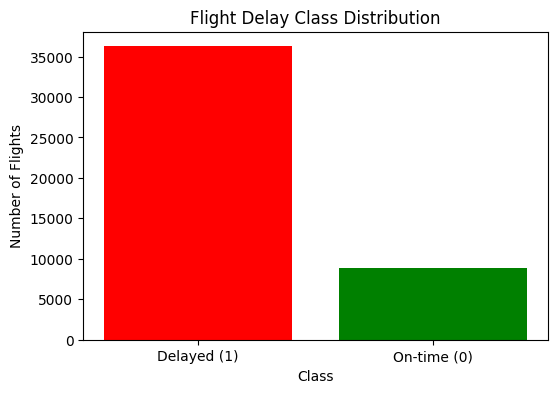

In [ ]:
# Counts from dataset
labels = ["Delayed (1)", "On-time (0)"]
counts = [36250, 8901]

# Plot
plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=["red", "green"])
plt.title("Flight Delay Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Flights")
plt.show()

In [ ]:
# Step 8: Training Corrected Model with Class Weights
# After analyzing class imbalance (Step 7), we retrain the model with weights 
# to reduce bias toward the majority (delayed flights).

# Step 8.1: Add class weights to training set
# Assign higher weights to minority class (on-time flights, label=0)
train_df_weighted = train_df.withColumn(
    "weight",
    F.when(F.col("label_delay_binary") == 0, 4.0).otherwise(1.0)  # weight ratio ~ delayed:ontime
)

# Step 8.2: Define weighted Random Forest model
rf_weighted = RandomForestClassifier(
    labelCol="label_delay_binary",
    featuresCol="features",
    weightCol="weight",    # ✅ NEW: weight column to handle imbalance
    numTrees=50,
    maxDepth=10,
    seed=42
)

# Step 8.3: Train model
rf_model_weighted = rf_weighted.fit(train_df_weighted)

# Step 8.4: Predictions on test set
predictions_weighted = rf_model_weighted.transform(test_df)
predictions_weighted.select(
    "label_delay_binary", "prediction", "probability"
).show(5, truncate=False)

# Step 8.5: Evaluation
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label_delay_binary", predictionCol="prediction", metricName="accuracy"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label_delay_binary", predictionCol="prediction", metricName="f1"
)

print("Corrected Model (Weighted)")
print("Accuracy:", evaluator_acc.evaluate(predictions_weighted))
print("F1 Score:", evaluator_f1.evaluate(predictions_weighted))


25/09/02 11:00:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.3 KiB
25/09/02 11:00:44 WARN DAGScheduler: Broadcasting large task binary with size 1369.7 KiB
25/09/02 11:00:45 WARN DAGScheduler: Broadcasting large task binary with size 1060.5 KiB
25/09/02 11:00:45 WARN DAGScheduler: Broadcasting large task binary with size 1070.6 KiB


+------------------+----------+----------------------------------------+
|label_delay_binary|prediction|probability                             |
+------------------+----------+----------------------------------------+
|0                 |1.0       |[0.49703321076720713,0.5029667892327929]|
|1                 |1.0       |[0.4948692090908296,0.5051307909091703] |
|1                 |1.0       |[0.49316360187800456,0.5068363981219954]|
|1                 |1.0       |[0.47712250574173143,0.5228774942582686]|
|0                 |1.0       |[0.4919060733834973,0.5080939266165028] |
+------------------+----------+----------------------------------------+
only showing top 5 rows
Corrected Model (Weighted)
Accuracy: 0.692752636951344
F1 Score: 0.6944017931272857


25/09/02 11:00:45 WARN DAGScheduler: Broadcasting large task binary with size 1070.6 KiB


In [ ]:
# Step 8.1: Confusion Matrix (Corrected Model)
confusion_matrix_weighted = predictions_weighted.groupBy(
    "label_delay_binary", "prediction"
).count().orderBy("label_delay_binary", "prediction")

confusion_matrix_weighted.show()


25/09/02 11:00:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.0 KiB


+------------------+----------+-----+
|label_delay_binary|prediction|count|
+------------------+----------+-----+
|                 0|       0.0|  321|
|                 0|       1.0| 1331|
|                 1|       0.0| 1378|
|                 1|       1.0| 5787|
+------------------+----------+-----+



In [ ]:
# Compute TP, FP, TN, FN from predictions
cm = predictions_weighted.groupBy("label_delay_binary", "prediction").count()
cm.show()

25/09/02 11:00:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.0 KiB


+------------------+----------+-----+
|label_delay_binary|prediction|count|
+------------------+----------+-----+
|                 1|       0.0| 1378|
|                 0|       0.0|  321|
|                 1|       1.0| 5787|
|                 0|       1.0| 1331|
+------------------+----------+-----+



In [ ]:
# Extract values
TP = cm.filter((F.col("label_delay_binary") == 1) & (F.col("prediction") == 1)).select("count").collect()[0][0]
FP = cm.filter((F.col("label_delay_binary") == 0) & (F.col("prediction") == 1)).select("count").collect()[0][0]
TN = cm.filter((F.col("label_delay_binary") == 0) & (F.col("prediction") == 0)).select("count").collect()[0][0]
FN = cm.filter((F.col("label_delay_binary") == 1) & (F.col("prediction") == 0)).select("count").collect()[0][0]

# Compute metrics
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

25/09/02 11:00:46 WARN DAGScheduler: Broadcasting large task binary with size 1075.2 KiB
25/09/02 11:00:46 WARN DAGScheduler: Broadcasting large task binary with size 1075.2 KiB
25/09/02 11:00:47 WARN DAGScheduler: Broadcasting large task binary with size 1075.2 KiB
25/09/02 11:00:47 WARN DAGScheduler: Broadcasting large task binary with size 1075.2 KiB


Precision: 0.8130
Recall: 0.8077


25/09/02 11:00:47 WARN DAGScheduler: Broadcasting large task binary with size 1025.9 KiB
25/09/02 11:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1055.0 KiB


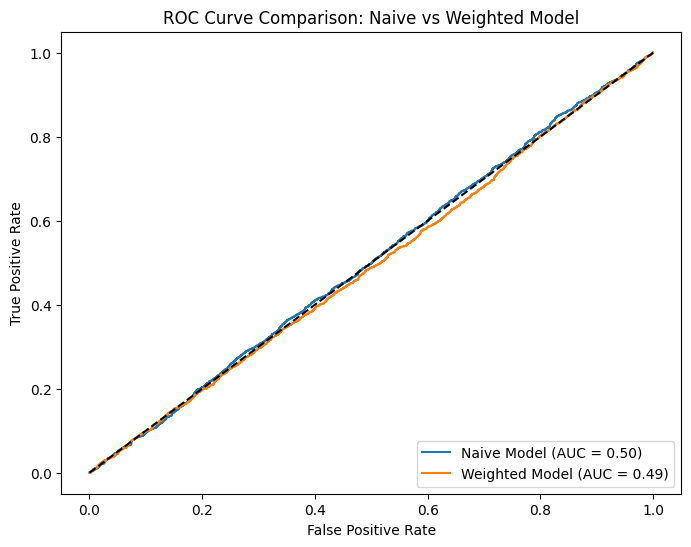

In [ ]:
# --- Naive Model ---
preds_naive_pd = predictions.select("label_delay_binary", "probability").toPandas()
y_true_naive = preds_naive_pd["label_delay_binary"]
y_score_naive = preds_naive_pd["probability"].apply(lambda x: float(x[1]))

fpr_naive, tpr_naive, _ = roc_curve(y_true_naive, y_score_naive)
roc_auc_naive = auc(fpr_naive, tpr_naive)

# --- Weighted Model ---
preds_weighted_pd = predictions_weighted.select("label_delay_binary", "probability").toPandas()
y_true_weighted = preds_weighted_pd["label_delay_binary"]
y_score_weighted = preds_weighted_pd["probability"].apply(lambda x: float(x[1]))

fpr_weighted, tpr_weighted, _ = roc_curve(y_true_weighted, y_score_weighted)
roc_auc_weighted = auc(fpr_weighted, tpr_weighted)

# --- Plot both ---
plt.figure(figsize=(8,6))
plt.plot(fpr_naive, tpr_naive, label=f"Naive Model (AUC = {roc_auc_naive:.2f})")
plt.plot(fpr_weighted, tpr_weighted, label=f"Weighted Model (AUC = {roc_auc_weighted:.2f})")
plt.plot([0,1],[0,1],'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Naive vs Weighted Model")
plt.legend(loc="lower right")
plt.show()
